In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import pandas as pd
import numpy as np
import datetime
import pytz
import os
import glob
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa import stattools
from scipy.signal import savgol_filter

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [167]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context('notebook', font_scale=1.5,rc={"lines.linewidth": 2.5})
sns.set_palette(sns.color_palette("Paired"))

In [2]:
#Please change to the location of the git_hub reporsitory
os.chdir('/Users/nehrend/work/algo_trading_book/')

In [6]:
trade = pd.read_pickle('./datasets/trade_data.gzip').sort_index()

In [16]:
amzn = trade.loc[pd.IndexSlice['AMZN','2016-10-03'],['Size','Price']]

In [12]:
amzn_profile = pd.read_csv('./datasets/amzn_profile.csv')
amzn_profile = amzn_profile.assign(time = pd.to_timedelta(amzn_profile.time)).set_index('time')

In [22]:
def vwap(df):
    d = {}
    d['vwap'] = (df['Size']*df['Price']).sum()/df['Size'].sum()
    return pd.Series(data = d)

min_vwap = amzn.reset_index().groupby(pd.Grouper(key='Timestamp',freq='1MIN')).apply(vwap)

In [100]:
order = 100000
vwap = order*amzn_profile.rename(columns={'profile':'exec_shares'})
vwap = vwap.assign(exec_price= min_vwap.vwap.values,exec_shares = np.round(vwap.exec_shares/100)*100 )

In [104]:
#adjust to ensure order size matches
e_lots = int((order - vwap.exec_shares.sum())/100)
vwap.iloc[np.random.choice(range(390),np.abs(e_lots)),0] += np.sign(e_lots)*100

In [195]:
def bin_30_f(df):
    d = {}
    d['exec_shares'] = df['exec_shares'].sum()
    d['exec_price'] = (df['exec_shares']*df['exec_price']).sum()/df['exec_shares'].sum()
    return pd.Series(data = d)
bin_30 = vwap.reset_index().groupby(pd.Grouper(key='time', freq='30MIN')).apply(bin_30_f)

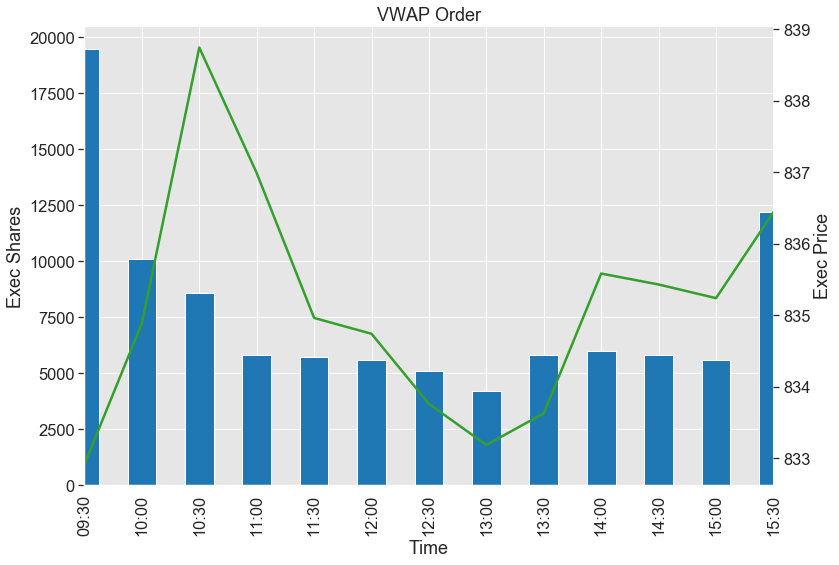

In [218]:
bin_30_p = bin_30.reset_index().assign(time_str = pd.to_datetime(bin_30.time).dt.strftime("%H:%M")).reset_index()
fix, ax = plt.subplots(figsize=(12,8))
_ = bin_30_p.plot.bar(x='time_str',y='exec_shares',ax =ax,color='C1',legend=None)
_ = ax.set_xlabel('Time')
_ = ax.set_ylabel('Exec Shares')
ax2 = ax.twinx()
_ = bin_30_p.plot(x='time_str',y='exec_price',color='C3',ax=ax2,legend=None)
_ = ax2.set_ylabel('Exec Price')
_ = ax2.grid(None)
sns.despine()
plt.tight_layout()
plt.savefig('./book/chapters/chapter_exec_models/figures/vwap.png', format='png', dpi=300)
plt.title('VWAP Order')
plt.show()

In [215]:
order = 100000
twap = amzn_profile.copy().assign(profile=np.ones(390)/390)
twap = order*twap.rename(columns={'profile':'exec_shares'}).assign()
twap = twap.assign(exec_price= min_vwap.vwap.values,exec_shares = np.round(twap.exec_shares/100)*100 )

In [216]:
e_lots = int((order - twap.exec_shares.sum())/100)
twap.iloc[np.random.choice(range(390),np.abs(e_lots)),0] += np.sign(e_lots)*100

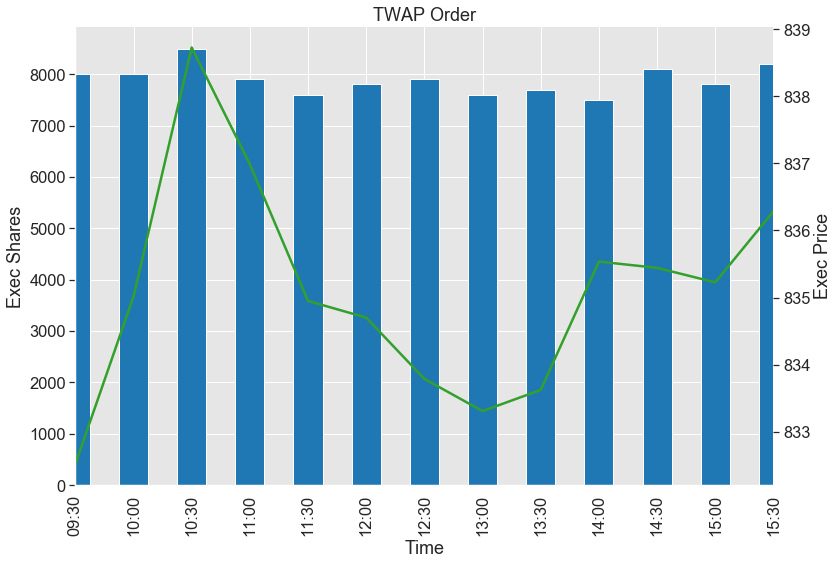

In [217]:
bin_30_t = twap.reset_index().groupby(pd.Grouper(key='time', freq='30MIN')).apply(bin_30_f).reset_index()
bin_30_p = bin_30_t.reset_index().assign(time_str = pd.to_datetime(bin_30.time).dt.strftime("%H:%M"))
fix, ax = plt.subplots(figsize=(12,8))
_ = bin_30_p.plot.bar(x='time_str',y='exec_shares',ax =ax,color='C1',legend=None)
_ = ax.set_xlabel('Time')
_ = ax.set_ylabel('Exec Shares')
ax2 = ax.twinx()
_ = bin_30_p.plot(x='time_str',y='exec_price',color='C3',ax=ax2,legend=None)
_ = ax2.set_ylabel('Exec Price')
_ = ax2.grid(None)
sns.despine()
plt.tight_layout()
plt.savefig('./book/chapters/chapter_exec_models/figures/twap.png', format='png', dpi=300)
plt.title('TWAP Order')
plt.show()

In [201]:
bin_30_p

,index,time,exec_shares,exec_price,time_str
0,0,09:30:00,19500.0,832.918362,09:30
1,1,10:00:00,10100.0,834.886728,10:00
2,2,10:30:00,8600.0,838.743380,10:30
3,3,11:00:00,5800.0,836.988771,11:00
4,4,11:30:00,5700.0,834.963238,11:30
5,5,12:00:00,5600.0,834.741718,12:00
6,6,12:30:00,5100.0,833.761409,12:30
7,7,13:00:00,4200.0,833.187520,13:00
8,8,13:30:00,5800.0,833.629929,13:30
9,9,14:00:00,6000.0,835.583658,14:00
